In [1]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("PySpark SQL basic example") \
    .config("spark.jars", "postgresql-42.3.6.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/newsscraper") \
    .option("dbtable", "articles") \
    .option("user", "root") \
    .option("password", "root") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()

Defaulting to user installation because normal site-packages is not writeable
22/07/15 13:57:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/15 13:57:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
root
 |-- sk: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- summary: string (nullable = true)



In [2]:
!pip install pyarrow
import matplotlib.pyplot as plt
from pyspark.sql.functions import split, lit

Defaulting to user installation because normal site-packages is not writeable


+--------------+-----+
|        domain|count|
+--------------+-----+
|   theguardian| 2845|
|       nytimes| 2059|
|washingtonpost| 1805|
|           bbc| 1655|
|       foxnews|  873|
|       cbsnews|  730|
|  sciencedaily|  482|
|        sltrib|  436|
|           cnn|  323|
|           npr|  305|
|         wired|  179|
|      usatoday|  167|
|    smartbrief|  118|
|           vox|  117|
|           ksl|   91|
|     newyorker|   86|
|      macworld|   50|
|   thespectrum|   36|
|            ed|   12|
|          utah|    7|
+--------------+-----+
only showing top 20 rows



[]

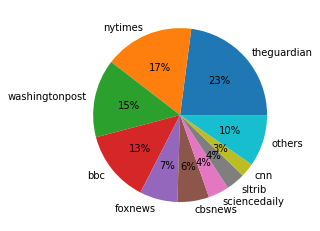

In [3]:
df_with_domain = df.withColumn('domain', split(df['url'],'\.').getItem(1))
domains = df_with_domain.select('domain')
domains = domains.select('domain').groupBy('domain').count().orderBy('count',ascending=False)
# get only top 20, 20 is the default value for show()
domains.show()

# Show top 9 domains, aggregate the rest
temporary = domains.select('domain','count').limit(9)
others = domains.subtract(temporary).select(lit('others'),'count').groupBy('others').sum('count')
domains = domains.select('domain','count').limit(9).union(others)

domains_pandas_df = domains.toPandas().head(10)
plt.pie(domains_pandas_df['count'], labels = domains_pandas_df['domain'],  autopct='%1.0f%%')
plt.plot()

In [4]:
from pyspark.sql.functions import explode, cast, udf, trim
import re
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist += list(map(lambda x: x.capitalize(),stoplist))
stoplist.append('–')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
clean_text = udf(lambda x: re.sub('[^a-zA-Z\-0-9]+?',"",x))

In [6]:
df2 = df.withColumn('words',split(df['title'],' '))
df2 = df2.withColumn('words',explode(df2['words']))
df2 = df2.withColumn('words',clean_text(df2['words'])).select('words')
words = df2.filter(~(df2['words'].isin(stoplist)))

In [7]:
# get the count
words = words.groupBy('words').count().orderBy('count',ascending = False).where("words != ''")

+--------+-----+
|   words|count|
+--------+-----+
|    says|  430|
|      US|  419|
| Ukraine|  366|
|shooting|  355|
|     New|  327|
|   Texas|  282|
|  school|  281|
|  review|  274|
|     new|  235|
|   Biden|  212|
|     gun|  210|
|     war|  203|
|      UK|  201|
|  police|  183|
|  Russia|  168|
|   could|  165|
|  Uvalde|  162|
| Russian|  159|
|    2022|  158|
|    Utah|  152|
+--------+-----+
only showing top 20 rows



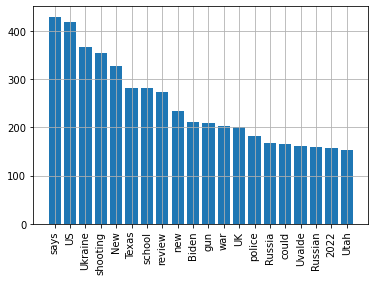

In [8]:
words.show()
words_pandas_df = words.toPandas().head(20)
plt.bar(words_pandas_df['words'],words_pandas_df['count'])
plt.xticks(rotation = 'vertical') # Make it more readable
plt.grid() # Just because I like grids

+----------+-----+
|      date|count|
+----------+-----+
|2022-06-03| 1038|
|2022-06-02|  696|
|2022-06-01|  829|
|2022-05-31|  544|
|2022-05-30|  256|
|2022-05-29|  496|
|2022-05-27| 1049|
|2022-05-26|  990|
|2022-05-25|  626|
|2022-05-24|  673|
|2022-05-23|  716|
|2022-05-22|  566|
|2022-05-21|  312|
|2022-05-20|  799|
|2022-05-19|  635|
|2022-05-18|  748|
|2022-05-17|  839|
|2022-05-16|  587|
+----------+-----+



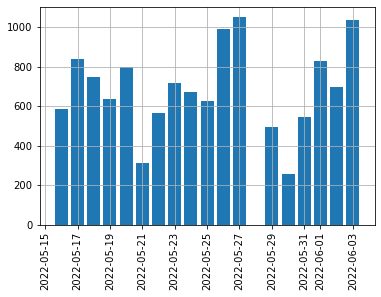

In [9]:
# Articles per day
df3 = df.groupBy('date').count().orderBy('date',ascending = False)
df3.show()

df3_pandas_df = df3.toPandas()
plt.bar(df3_pandas_df['date'],df3_pandas_df['count'])
plt.xticks(rotation='vertical')
plt.grid()